In [1]:
# Opensa raster, trims it to extent of catchment, saves a trimmed version
# and returns an arrat contianing the data, also trimmed
def open_and_clip(input_raster_fp):
    # Read in data as array
    data = rasterio.open(input_raster_fp)
    # Create a bounding box 
    minx, miny = 437000,  426500
    maxx, maxy = 445500, 434300
    bbox = box(minx, miny, maxx, maxy)
    # Insert the bbox into a GeoDataFrame
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=CRS('EPSG:27700'))     
    # Re-project into the same coordinate system as the raster data
    geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

    # Next we need to get the coordinates of the geometry in such a format
    # that rasterio wants them. This can be conducted easily with following function
    # Get the geometry coordinates by using the function.
    coords = getFeatures(geo)

    # Clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily 
    # with the mask function and specifying clip=True.
    clipped_array, out_transform = mask(data, shapes=coords, crop=True)

    # # Set -9999 to NA
    if np.isnan(np.sum(clipped_array)) == True:
        clipped_array[clipped_array < -9998] = np.nan
        clipped_array[clipped_array < -9999] = np.nan
    else:
        clipped_array = clipped_array.astype('float') 
        clipped_array[clipped_array ==0] = np.nan

    # Modify the metadata. Let’s start by copying the metadata from the original data file.
    out_meta = data.meta.copy()
    # Parse the EPSG value from the CRS so that we can create a Proj4 string using PyCRS library 
    # (to ensure that the projection information is saved correctly) [this bit didn't work so specified manually]
    #epsg_code = int(data.crs.data['init'][5:])
    # Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text)
    out_meta.update({"driver": "GTiff","height": clipped_array.shape[1],"width": clipped_array.shape[2], 
                     "transform": out_transform, "crs": CRS('EPSG:27700')})#pycrs.parser.from_epsg_code(epsg_code).to_proj4()})

    return clipped_array[0,:,:], out_meta

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def save_array_as_raster(raster, fp_to_save, out_meta):
    #src = rasterio.open("MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif")
    with rasterio.open(
            fp_to_save, "w", **out_meta) as dest_file:
        dest_file.write(raster,1)
    dest_file.close()      

def prep_for_folium_plotting(input_raster_fp):
    # Open dataset using rioxarray
    xarray_dataarray = rxr.open_rasterio(input_raster_fp).squeeze()
    # reproject
    xarray_dataarray.rio.set_crs("EPSG:27700")
    xarray_dataarray = xarray_dataarray.rio.reproject("EPSG:4326", nodata = np.nan)
    return xarray_dataarray

def colorize(array, cmap):
    normed_data = (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array)) 
    #normed_data = (array - array.min()) / (array.max() - array.min()) 
    cm = plt.cm.get_cmap(cmap)    
    return np.uint8(cm(normed_data)  * 255)

In [2]:
import sys
import os
import folium
import numpy.ma as ma
from folium import Map, FeatureGroup, LayerControl
import rasterio
from shapely.geometry import box
import geopandas as gpd
from pyproj import CRS
from rasterio.mask import mask
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import rioxarray as rxr
from rasterio import plot

# Define whether to filter out values <0.1
remove_little_values = True

In [4]:
model_directory = '../../../FloodModelling/Model_IdealisedProfiles/'

# Specify catchment area to add to plot
catchment_shp = model_directory + "CatchmentLinDyke_exported.shp"
catchment_gdf = gpd.read_file(catchment_shp)

### Read in the resized land cover file, clip it and update some parameters 

In [6]:
landcover, out_meta = open_and_clip( '../../../FloodModelling/LandCoverData/' + "LandCover_resized.tif")
out_meta.update({"nodata":np.nan, "dtype" :'float64' })
landcover[landcover == -2147483648] = np.nan
save_array_as_raster(landcover, model_directory +"LandCover_clipped.tif", out_meta)

### Check the shape

In [7]:
np.count_nonzero(~np.isnan(landcover))
np.unique(landcover)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

### Plot

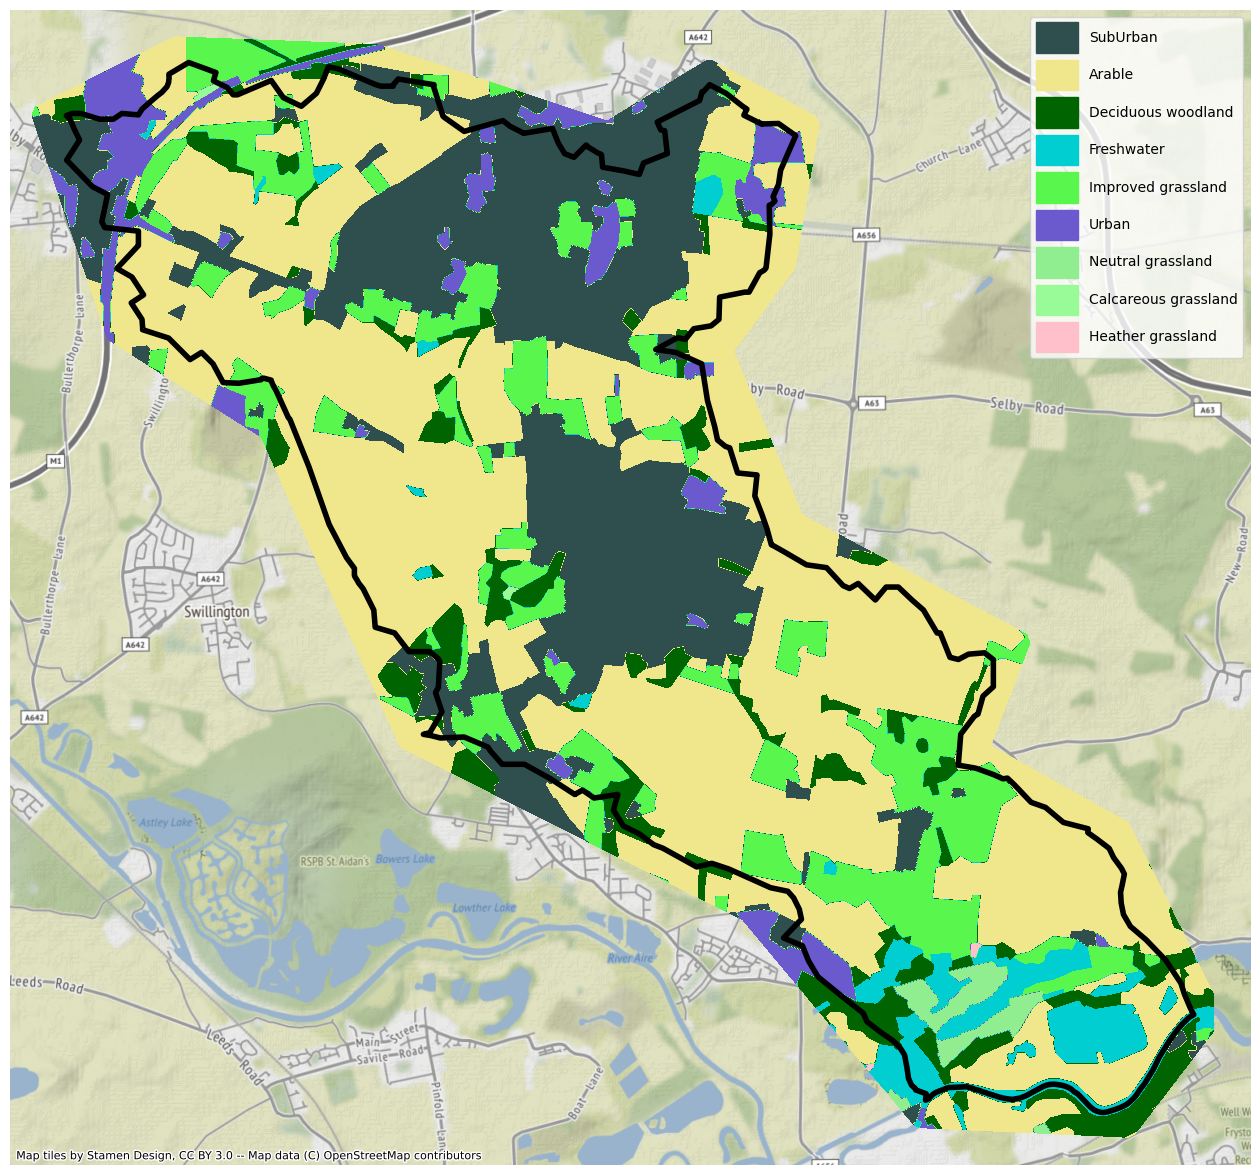

In [10]:
clipped = rasterio.open(model_directory +"LandCover_clipped.tif")
labels= ['SubUrban', 'Arable', 'Deciduous woodland', 'Freshwater', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland']
colors = ['darkslategrey', 'khaki', 'darkgreen','darkturquoise','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink']
cmap = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(20, 15))
catchment_gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
plot.show((clipped, 1), ax= ax, cmap=cmap)

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()

# Create patches for legend
patches_list = []
for i, color in  enumerate(colors):
    patch =  mpatches.Patch(color=color, label=labels[i])
    patches_list.append(patch)  

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()
plt.axis('off')
plt.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =10);

In [11]:
# Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  
landcover_mod =  np.where(landcover==1, 10, landcover)
landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
# Convert the rest of the classes to 11
for i in [1,2,3,4,5,7,8,9]:
    landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)

### Find proportion of cells that are urban

In [12]:
unique_vals = np.unique(landcover_mod, return_counts=True)
round((unique_vals[1][0] / (unique_vals[1][0] + unique_vals[1][1])) * 100,2)

27.0

In [13]:
# np.count_nonzero(~np.isnan(landcover_mod))
np.count_nonzero(landcover_mod == 10)
np.count_nonzero(~np.isnan(landcover_mod))

29589134

In [14]:
save_array_as_raster(landcover_mod, model_directory +"LandCover_clipped_reclassified.tif", out_meta)

### Plot with folium (to check covering the right area)

In [30]:
# Set up figure
f = folium.Figure(width=800, height=700)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=13).add_to(f)
folium.TileLayer(
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

# Add to map
catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                                          fillColor='#00000000', color='Black': {
        "fillColor": '#00000000',"color": 'Black',}))
name = 'land_classified'

xarray_dataarray = prep_for_folium_plotting(model_directory +"LandCover_clipped_reclassified.tif")
# Get coordinates needed in plotting
clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
# Apply colormap
data  = ma.masked_invalid(xarray_dataarray.values)
colored_data = colorize(data.data, cmap=cmap)
# Add to map
feature_group1 = FeatureGroup(name=name)
feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,
                          [[mlat, mlon], [xlat, xlon]],
                          opacity=0.8,interactive=True, popup=name))
mapa.add_child(feature_group1)

# Add layer control button
mapa.add_child(catchment_boundary_feature_group)
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)

## Filter analysis by just Kippax/Garforth

In [16]:
all_boundaries = gpd.read_file("../../../FloodModelling/KippaxBoundary/Parishes/Parishes_December_2016_FCB_in_England_and_Wales.shp")

In [33]:
all_boundaries[all_boundaries['lad16nm']=='Leeds']


,OBJECTID,par16cd,par16nm,par16nmw,lad16cd,lad16nm,bng_e,bng_n,long,lat,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
162,163,E04000186,Aberford,None,E08000035,Leeds,442901,438457,-1.34950,53.840599,{B1B7EF6E-8244-4EFE-B7A7-61A34F6B0B57},14005.932168,6.380927e+06,"POLYGON ((442656.904 440250.199, 442710.200 44..."
163,164,E04000187,Arthington,None,E08000035,Leeds,427380,444634,-1.58482,53.897202,{5FECBB41-780E-410D-95DE-341616EAEE2E},17763.462835,7.958629e+06,"POLYGON ((429495.296 445295.805, 429476.399 44..."
164,165,E04000188,Austhorpe,None,E08000035,Leeds,438702,433382,-1.41395,53.795300,{8494D35E-A6DA-4676-81F7-D0EAC138B6EE},6157.200010,1.241881e+06,"POLYGON ((439990.698 433779.301, 439952.598 43..."
165,166,E04000190,Barwick in Elmet and Scholes,None,E08000035,Leeds,439152,438084,-1.40652,53.837601,{584666B8-4F3C-4DB1-8102-8CA9112A14CE},29719.663984,1.932560e+07,"POLYGON ((440514.697 442385.998, 440491.000 44..."
166,167,E04000195,Clifford,None,E08000035,Leeds,442329,444651,-1.35734,53.896301,{EA00ABBA-B82B-4C11-95E9-C54CF26C776E},9613.871615,2.998117e+06,"POLYGON ((443559.903 444554.797, 443557.899 44..."
167,168,E04000196,Collingham,None,E08000035,Leeds,439150,445717,-1.40558,53.906200,{5DEF134F-68E2-499D-9366-C5E6AE17787D},18847.902615,1.148996e+07,"POLYGON ((439056.096 448129.903, 439070.698 44..."
168,169,E04000197,East Keswick,None,E08000035,Leeds,435929,445229,-1.45466,53.902000,{6DB3BB44-A169-4E95-B301-DFC30D293ECC},13373.905559,5.262145e+06,"POLYGON ((437253.000 446149.000, 437268.600 44..."
169,170,E04000198,Great and Little Preston,None,E08000035,Leeds,439753,429554,-1.39849,53.760799,{110624D1-B203-49EC-888B-2537FC833639},10353.528331,4.198772e+06,"POLYGON ((440284.503 430964.697, 440277.997 43..."
170,171,E04000199,Harewood,None,E08000035,Leeds,432073,443168,-1.51356,53.883701,{731FCF99-51FD-4C39-874B-53137EAB7556},28944.096693,2.716665e+07,"POLYGON ((434870.499 446256.800, 434863.103 44..."
171,172,E04000200,Ledsham,None,E08000035,Leeds,445333,429918,-1.31380,53.763699,{0527FDDC-9BC0-4F27-AA4E-BF99D2B89409},19071.488720,8.235168e+06,"POLYGON ((445313.396 431908.397, 445329.400 43..."


In [34]:
kippax_boundary = all_boundaries[all_boundaries['par16nm'] == 'Swillington']

In [36]:
raster = rxr.open_rasterio(file, masked=True).squeeze()
raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])   

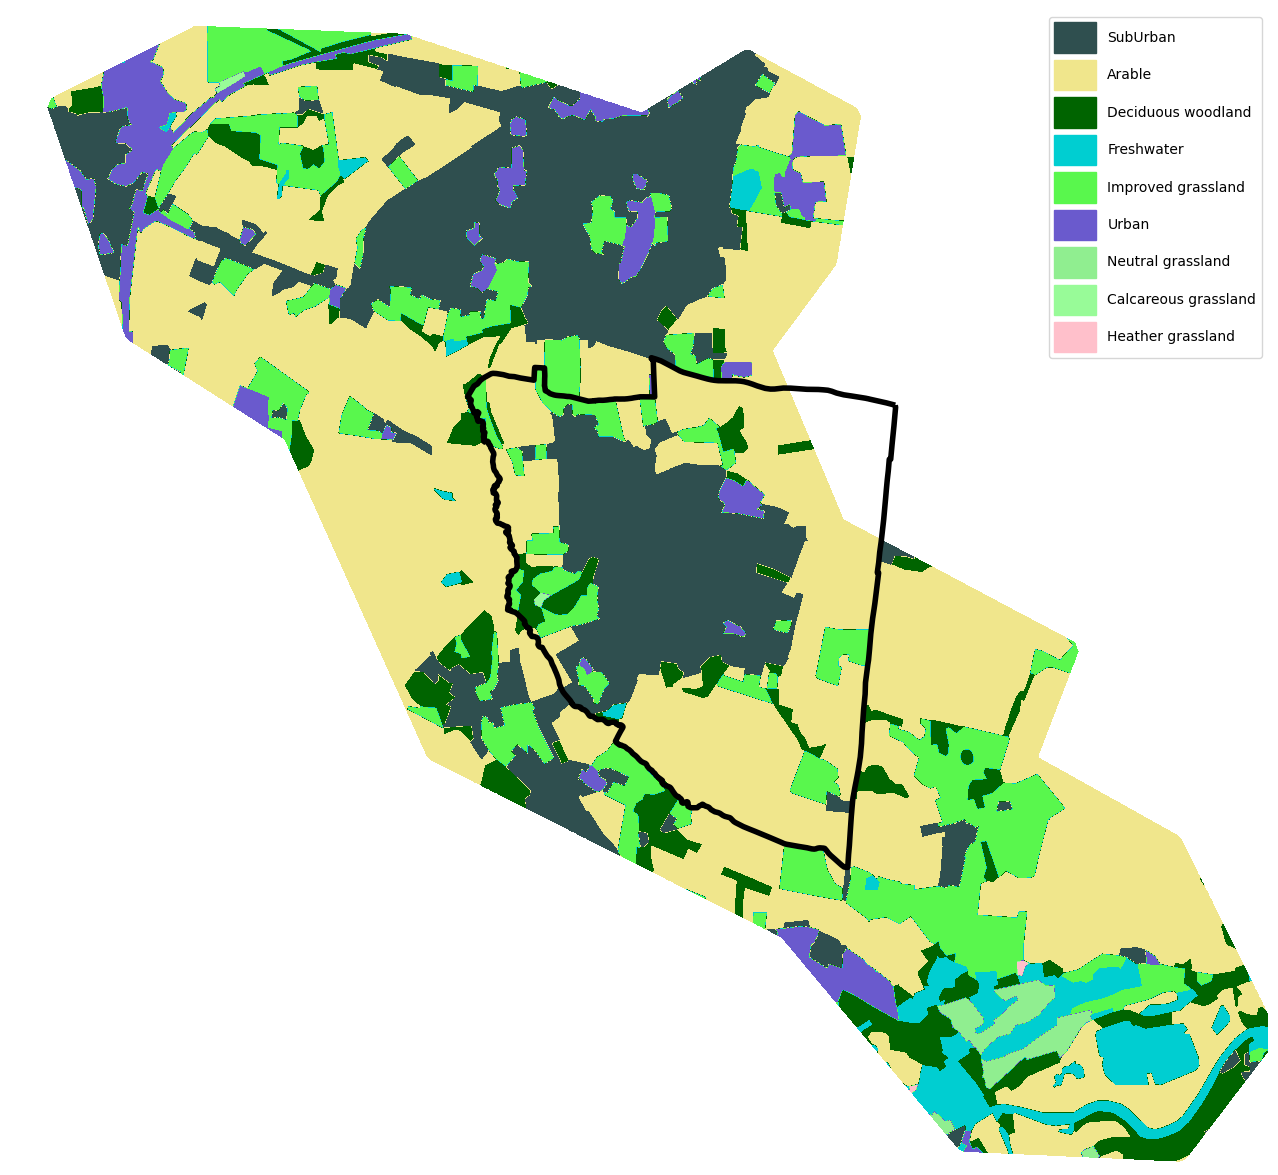

In [20]:
clipped = rasterio.open(model_directory +"LandCover_clipped.tif")
labels= ['SubUrban', 'Arable', 'Deciduous woodland', 'Freshwater', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland']
colors = ['darkslategrey', 'khaki', 'darkgreen','darkturquoise','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink']
cmap = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(20, 15))
kippax_boundary.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
# cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
plot.show((clipped, 1), ax= ax, cmap=cmap)

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()

# Create patches for legend
patches_list = []
for i, color in  enumerate(colors):
    patch =  mpatches.Patch(color=color, label=labels[i])
    patches_list.append(patch)  

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()
plt.axis('off')
plt.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =10);

In [26]:
from shapely.geometry import mapping

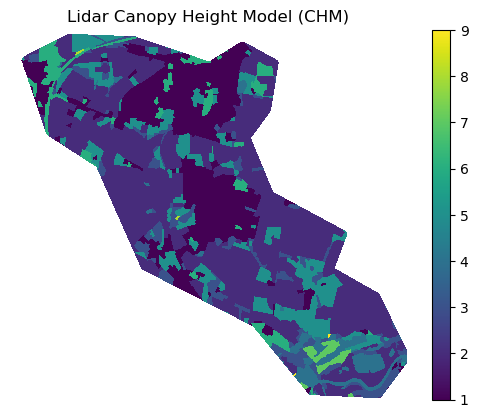

In [25]:
# lidar_chm_im = rxr.open_rasterio(model_directory +"LandCover_clipped.tif", masked=True).squeeze()

f, ax = plt.subplots()
lidar_chm_im.plot.imshow()
ax.set(title="Lidar Canopy Height Model (CHM)")

ax.set_axis_off()
plt.show()


# model_directory +"LandCover_clipped.tif"
# lidar_clipped = clipped.rio.clip(kippax_boundary.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       crop_extent.crs)

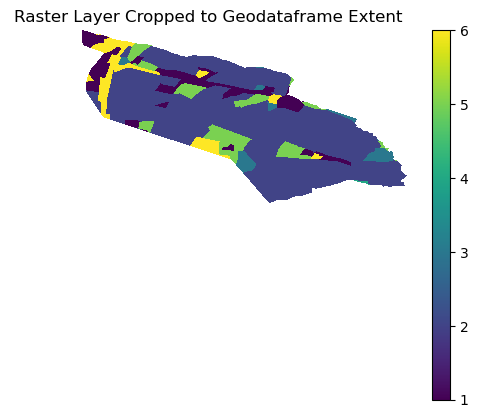

In [37]:
kippax_boundary = all_boundaries[all_boundaries['par16nm'] == 'Swillington']
lidar_clipped = lidar_chm_im.rio.clip(kippax_boundary.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      kippax_boundary.crs)

f, ax = plt.subplots()
lidar_clipped.plot(ax=ax)
ax.set(title="Raster Layer Cropped to Geodataframe Extent")
ax.set_axis_off()
plt.show()

In [40]:
catchment_boundary_feature_group

In [42]:
# Set up figure
f = folium.Figure(width=800, height=700)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=13).add_to(f)
folium.TileLayer(
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

# Add to map
catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                                          fillColor='#00000000', color='Black': {
        "fillColor": '#00000000',"color": 'Black',}))

kippax_boundary_feature_group = FeatureGroup(name='Kippax boundary')
kippax_boundary_feature_group.add_child(folium.GeoJson(data=kippax_boundary["geometry"], style_function=lambda x, 
                                                          fillColor='#00000000', color='Black': {
        "fillColor": '#00000000',"color": 'Black',}))

# Add layer control button
mapa.add_child(catchment_boundary_feature_group)
mapa.add_child(kippax_boundary_feature_group)
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)